<a href="https://colab.research.google.com/github/mobarakol/AI_Medical_Imaging/blob/main/Practical_2_Longitudinal_Image_ConvAttention_ConvSSM_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download 2D Slices of Dementia Longitudina Data
Sagital Slices of the MRIs have been extracted from two time points. <br>
Original MRI can be found here: https://sites.wustl.edu/oasisbrains/home/oasis-2/<br>

Original label can be found here: https://www.kaggle.com/datasets/jboysen/mri-and-alzheimers <br> or https://www.kaggle.com/datasets/abdelazizsami/oasis-longitudinal

In [1]:
!gdown 1GAIX63ttx2eKg693KEiwki7MGqJBavPC
!unzip -q OAS2_Longitudinal.zip

Downloading...
From: https://drive.google.com/uc?id=1GAIX63ttx2eKg693KEiwki7MGqJBavPC
To: /content/OAS2_Longitudinal.zip
100% 13.1M/13.1M [00:00<00:00, 58.1MB/s]


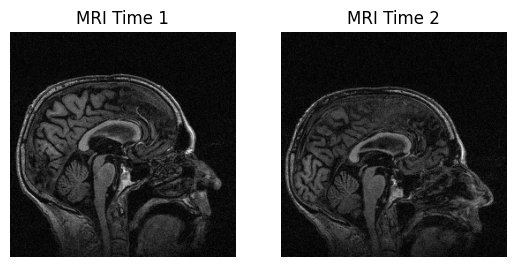

In [2]:
import matplotlib.pyplot as plt
import cv2
img_t1 = cv2.imread('/content/OAS2_Longitudinal/OAS2_0001/OAS2_0001_MR1.png')
img_t2 = cv2.imread('/content/OAS2_Longitudinal/OAS2_0001/OAS2_0001_MR2.png')

plt.subplot(121); plt.axis('OFF');plt.title('MRI Time 1');plt.imshow(img_t1)
plt.subplot(122); plt.axis('OFF');plt.title('MRI Time 2');plt.imshow(img_t2)

#Prepare Datalaoder

In [3]:
import os
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

class OASISLongitudinalDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with columns 'patient_id' and 'label'.
            root_dir (str): Directory containing patient folders with images.
            transform (callable, optional): Optional transform to be applied on images.
        """
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = {"Nondemented": 0, "Demented": 1, "Converted": 2}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # Get patient_id and label
        patient_id = self.data.iloc[idx]['patient_id']
        label = self.data.iloc[idx]['label']
        label = self.label_map[label]
        label = torch.tensor(label, dtype=torch.long)

        # Construct paths to the two longitudinal images
        patient_dir = os.path.join(self.root_dir, patient_id)
        mri1_path = os.path.join(patient_dir, patient_id+'_MR1.png')
        mri2_path = os.path.join(patient_dir, patient_id+'_MR2.png')

        # Load images
        mri1 = Image.open(mri1_path).convert('RGB')
        mri2 = Image.open(mri2_path).convert('RGB')

        # Apply transforms if specified
        if self.transform:
            mri1 = self.transform(mri1)
            mri2 = self.transform(mri2)

        return {'patient_id': patient_id, 'label': label, 'MRI1': mri1, 'MRI2': mri2}

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor()           # Convert images to PyTorch tensors
])

root_dir = '/content/OAS2_Longitudinal'
label_map_csv = '/content/OAS2_Longitudinal/oasis_longitudinal_label.csv'
dataset = OASISLongitudinalDataset(label_map_csv, root_dir, transform=transform)

#Spliting first 80% into training and remaining 20% into validation

# Calculate split indices
total_size = len(dataset)
train_size = int(0.8 * total_size)  # First 80%
val_size = total_size - train_size  # Remaining 20%

# Assign indices for training and validation
indices = list(range(total_size))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Create Subset datasets for training and validation
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
print('Total Sample Size:', len(dataset), 'Training Sample:', len(train_dataset), 'Validation Sample:', len(val_dataset))

from collections import Counter
labels = [sample['label'].item() for sample in train_dataset]
print('Class Frequency in Training Set:', Counter(labels))

labels = [sample['label'].item() for sample in val_dataset]
print('Class Frequency in Validation Set:', Counter(labels))


Total Sample Size: 150 Training Sample: 120 Validation Sample: 30
Class Frequency in Training Set: Counter({0: 58, 1: 49, 2: 13})
Class Frequency in Validation Set: Counter({1: 15, 0: 14, 2: 1})


Attention Model Architecture using Pytorch:

In [4]:
import torch
import torch.nn as nn

class ConvAttentionClassifier(nn.Module):
    def __init__(self, input_channels, hidden_dim, num_classes=None):
        super(ConvAttentionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Linear projection for input to attention mechanism
        self.input_proj = nn.Linear(32 * 128 * 128, hidden_dim)

        # Self-Attention layer
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len, channels, height, width = x.shape
        x = x.view(batch_size * seq_len, channels, height, width)

        # Convolutional layers
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))

        # Flatten and reshape for attention
        x = x.view(batch_size, seq_len, -1)  # Shape: [batch_size, seq_len, features]
        x = self.input_proj(x)              # Project to hidden_dim space

        # Apply self-attention
        attn_output, _ = self.attention(x, x, x)  # Shape: [batch_size, seq_len, hidden_dim]

        # Use the last time step for classification
        x = attn_output[:, -1, :]  # Shape: [batch_size, hidden_dim]
        x = self.fc(x)             # Shape: [batch_size, num_classes]

        return x

Training:

In [5]:
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, AdamW
import random
import numpy as np
import torch

def set_seed(seed):
    """
    Fix all random seeds for reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Example usage
set_seed(12)

# Initialize the dataset and dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Hyperparameters
input_channels = 3  # RGB images
hidden_dim = 128
num_classes = 3  # Binary classification (Demented/Nondemented)
learning_rate = 0.0001
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, loss function, and optimizer
model = ConvAttentionClassifier(input_channels, hidden_dim, num_classes=num_classes).to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Initialize variables to track the best validation loss
best_val_loss = float('inf')
best_model_path = "best_model.pth"
best_epoch = 0
best_accuracy = 0

# Training and Validation Loop
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        mri1, mri2, labels = batch['MRI1'].to(device), batch['MRI2'].to(device), batch['label'].to(device)
        inputs = torch.stack([mri1, mri2], dim=1)  # Shape: [batch_size, seq_len, channels, height, width]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # print(outputs.shape, labels.shape)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            mri1, mri2, labels = batch['MRI1'].to(device), batch['MRI2'].to(device), batch['label'].to(device)
            inputs = torch.stack([mri1, mri2], dim=1)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            # print(labels)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            # print('predicted:', predicted)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    accuracy = correct / total

    # Save the best model
    if accuracy > best_accuracy:
        best_val_loss = val_loss
        # torch.save(model.state_dict(), best_model_path)
        best_epoch = epoch
        best_accuracy = accuracy
        print(f"New best model saved with validation loss: {val_loss:.4f}, Acc:{best_accuracy:.4f}")

    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
      f"Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, "
      f"Best Epoch: {best_epoch}, Best Acc: {best_accuracy:.4f}")



New best model saved with validation loss: 1.0110, Acc:0.5333
Epoch [1/30], Train Loss: 1.1600, Val Loss: 1.0110, Accuracy: 0.5333, Best Epoch: 0, Best Acc: 0.5333
New best model saved with validation loss: 0.8064, Acc:0.5667
Epoch [2/30], Train Loss: 0.9413, Val Loss: 0.8064, Accuracy: 0.5667, Best Epoch: 1, Best Acc: 0.5667
Epoch [3/30], Train Loss: 0.8902, Val Loss: 0.8363, Accuracy: 0.5333, Best Epoch: 1, Best Acc: 0.5667
Epoch [4/30], Train Loss: 0.7925, Val Loss: 0.8717, Accuracy: 0.4667, Best Epoch: 1, Best Acc: 0.5667
New best model saved with validation loss: 0.7329, Acc:0.7333
Epoch [5/30], Train Loss: 0.6774, Val Loss: 0.7329, Accuracy: 0.7333, Best Epoch: 4, Best Acc: 0.7333
New best model saved with validation loss: 0.7736, Acc:0.7667
Epoch [6/30], Train Loss: 0.4517, Val Loss: 0.7736, Accuracy: 0.7667, Best Epoch: 5, Best Acc: 0.7667
New best model saved with validation loss: 0.6658, Acc:0.8333
Epoch [7/30], Train Loss: 0.2150, Val Loss: 0.6658, Accuracy: 0.8333, Best Epo

<p><b>Scaled Dot-Product Attention:</b></p>

<p><b>Attention Scores:</b></p>
<p><code>Attention_Scores = (Q × K&#x1D40B;) / &#8730;d</code></p>

<p><b>Attention Weights (Softmax Normalization):</b></p>
<p><code>Attention_Weights = softmax(Attention_Scores)</code></p>

<p><b>Attention Output:</b></p>
<p><code>Attention_Output = Attention_Weights × V</code></p>


#Task-1: Attention Model Architecture From Scratch

<p><b>Implement Scaled Dot-Product Attention:</b></p>

<p><b>Attention Scores:</b></p>
<p><code>Attention_Scores = (Q × K<sup>T</sup>) / &#8730;embed_dim</code></p>

<p><b>Attention Weights (Softmax Normalization):</b></p>
<p><code>Attention_Weights = softmax(Attention_Scores)</code></p>

<p><b>Attention Output:</b></p>
<p><code>Attention_Output = Attention_Weights × V</code></p>


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CustomMultiheadAttention, self).__init__()
        assert embed_dim % num_heads == 0, "Embed_dim must be divisible by num_heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Linear layers for query, key, and value projections
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)

        # Output projection
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, query, key, value):
        batch_size, seq_len, embed_dim = query.size()

        # Linear projections
        Q = self.q_proj(query)  # [batch_size, seq_len, embed_dim]
        K = self.k_proj(key)    # [batch_size, seq_len, embed_dim]
        V = self.v_proj(value)  # [batch_size, seq_len, embed_dim]

        # Reshape into multiple heads
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        ###################Task-1 Here ####################
        # Scaled dot-product attention
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5) # make sure, use of torch.matmul,  K^T = K.transpose(-2, -1), and √embed_dim = self.head_dim ** 0.5
        attention_weights = F.softmax(attention_scores, dim=-1) # make sure dim=-1
        attention_output = torch.matmul(attention_weights, V) #Add your code  # make sure, use of torch.matmul

        # Concatenate multiple heads
        attention_output = attention_output.transpose(1, 2).contiguous()
        attention_output = attention_output.view(batch_size, seq_len, embed_dim)

        # Final linear projection
        output = self.out_proj(attention_output)
        return output

class ConvCustomAttentionClassifier(nn.Module):
    def __init__(self, input_channels, hidden_dim, num_classes=None, num_heads=4):
        super(ConvCustomAttentionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Linear projection for attention
        self.input_proj = nn.Linear(32 * 128 * 128, hidden_dim)

        # Replace nn.MultiheadAttention with CustomMultiheadAttention
        self.attention = CustomMultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads)

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len, channels, height, width = x.shape
        x = x.view(batch_size * seq_len, channels, height, width)

        # Convolutional layers
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))

        # Flatten and reshape for attention
        x = x.view(batch_size, seq_len, -1)  # Shape: [batch_size, seq_len, features]
        x = self.input_proj(x)              # Project to hidden_dim space

        # Apply custom multi-head attention
        x = self.attention(x, x, x)  # Query, Key, and Value are the same

        # Use the last time step for classification
        x = x[:, -1, :]  # Shape: [batch_size, hidden_dim]
        x = self.fc(x)   # Shape: [batch_size, num_classes]

        return x


Training on custom attention model:

In [9]:
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, AdamW
import random
import numpy as np
import torch

def set_seed(seed):
    """
    Fix all random seeds for reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Example usage
set_seed(12)

# Initialize the dataset and dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Hyperparameters
input_channels = 3  # RGB images
hidden_dim = 128
num_classes = 3  # Binary classification (Demented/Nondemented)
learning_rate = 0.0001
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, loss function, and optimizer
model = ConvCustomAttentionClassifier(input_channels, hidden_dim, num_classes=num_classes).to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Initialize variables to track the best validation loss
best_val_loss = float('inf')
best_model_path = "best_model.pth"
best_epoch = 0
best_accuracy = 0

# Training and Validation Loop
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        mri1, mri2, labels = batch['MRI1'].to(device), batch['MRI2'].to(device), batch['label'].to(device)
        inputs = torch.stack([mri1, mri2], dim=1)  # Shape: [batch_size, seq_len, channels, height, width]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # print(outputs.shape, labels.shape)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            mri1, mri2, labels = batch['MRI1'].to(device), batch['MRI2'].to(device), batch['label'].to(device)
            inputs = torch.stack([mri1, mri2], dim=1)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            # print(labels)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            # print('predicted:', predicted)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    accuracy = correct / total

    # Save the best model
    if accuracy > best_accuracy:
        best_val_loss = val_loss
        # torch.save(model.state_dict(), best_model_path)
        best_epoch = epoch
        best_accuracy = accuracy
        print(f"New best model saved with validation loss: {val_loss:.4f}, Acc:{best_accuracy:.4f}")

    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
      f"Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, "
      f"Best Epoch: {best_epoch}, Best Acc: {best_accuracy:.4f}")



New best model saved with validation loss: 0.9693, Acc:0.5667
Epoch [1/30], Train Loss: 1.1149, Val Loss: 0.9693, Accuracy: 0.5667, Best Epoch: 0, Best Acc: 0.5667
New best model saved with validation loss: 0.8223, Acc:0.6333
Epoch [2/30], Train Loss: 0.9502, Val Loss: 0.8223, Accuracy: 0.6333, Best Epoch: 1, Best Acc: 0.6333
Epoch [3/30], Train Loss: 0.8962, Val Loss: 0.9558, Accuracy: 0.4667, Best Epoch: 1, Best Acc: 0.6333
New best model saved with validation loss: 0.8155, Acc:0.6667
Epoch [4/30], Train Loss: 0.8767, Val Loss: 0.8155, Accuracy: 0.6667, Best Epoch: 3, Best Acc: 0.6667
Epoch [5/30], Train Loss: 0.6766, Val Loss: 0.8100, Accuracy: 0.5667, Best Epoch: 3, Best Acc: 0.6667
New best model saved with validation loss: 0.7297, Acc:0.7667
Epoch [6/30], Train Loss: 0.5521, Val Loss: 0.7297, Accuracy: 0.7667, Best Epoch: 5, Best Acc: 0.7667
Epoch [7/30], Train Loss: 0.3402, Val Loss: 0.7017, Accuracy: 0.6333, Best Epoch: 5, Best Acc: 0.7667
Epoch [8/30], Train Loss: 0.1453, Val 

#Task-2 State Space Model from Scratch
Implement simplified SSM
<p><b>State Update Equation:</b></p>
<p><code>h = ReLU(h × A_norm<sup>T</sup> + u_t × B<sup>T</sup>)</code></p>

<p><b>Output Equation for the Current Time Step:</b></p>
<p><code>y_t = h × C<sup>T</sup></code></p>


In [6]:
import torch
import torch.nn as nn
import torch.fft

class SSMCore(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, seq_len):
        super(SSMCore, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len

        # State-space parameters (learnable)
        self.A = nn.Parameter(torch.eye(hidden_dim) + 0.01 * torch.randn(hidden_dim, hidden_dim))
        self.B = nn.Parameter(0.01 * torch.randn(hidden_dim, input_dim))
        self.C = nn.Parameter(0.01 * torch.randn(output_dim, hidden_dim))
        self.Lambda = nn.Parameter(torch.ones(hidden_dim) * 0.5)

    def forward(self, x):
        batch_size, seq_len, input_dim = x.size()

        # Initialize hidden state
        h = torch.zeros(batch_size, self.hidden_dim, device=x.device)
        outputs = []

        # Normalize A for stability
        A_norm = self.A / (torch.linalg.norm(self.A, ord=2) + 1e-5)

        for t in range(seq_len):
            u_t = x[:, t, :]  # Input at time step t, shape [batch_size, input_dim]

            ###################Task-2 Here ####################
            # State update equation
            h = torch.relu(h @ A_norm.T + u_t @ self.B.T)# Make sure × = @

            # Compute output for the current time step
            y_t = h @ self.C.T# Make sure × = @

            outputs.append(y_t)

        # Stack outputs along the sequence dimension
        y = torch.stack(outputs, dim=1)  # Shape: [batch_size, seq_len, output_dim]
        return y


class ConvSSMClassifier(nn.Module):
    def __init__(self, input_channels, hidden_dim, seq_len=2, num_classes=None):
        super(ConvSSMClassifier, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Replace LSTM with SSMCore
        self.ssm = SSMCore(input_dim=32 * 128 * 128, hidden_dim=hidden_dim, output_dim=hidden_dim, seq_len=seq_len)

        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size, seq_len, channels, height, width = x.shape
        x = x.view(batch_size * seq_len, channels, height, width)

        # Convolutional layers
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))

        # Reshape for SSM
        x = x.view(batch_size, seq_len, -1)  # Shape: [batch_size, seq_len, features]

        # State space model (SSM)
        x = self.ssm(x)  # Shape: [batch_size, seq_len, hidden_dim]

        # Use the last time step for classification
        x = x[:, -1, :]  # Shape: [batch_size, hidden_dim]

        # Fully connected layer (classification)
        x = self.fc(x)   # Shape: [batch_size, num_classes]
        return x

Training SSM

In [7]:
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, AdamW
import random
import numpy as np
import torch

def set_seed(seed):
    """
    Fix all random seeds for reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Example usage
set_seed(12)

# Initialize the dataset and dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Hyperparameters
input_channels = 3  # RGB images
hidden_dim = 128
seq_len = 2
num_classes = 3  # Binary classification (Demented/Nondemented)
learning_rate = 0.0001
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model, loss function, and optimizer
model = ConvSSMClassifier(input_channels, hidden_dim, seq_len=seq_len, num_classes=num_classes).to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Initialize variables to track the best validation loss
best_val_loss = float('inf')
best_model_path = "best_model.pth"
best_epoch = 0
best_accuracy = 0

# Training and Validation Loop
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        mri1, mri2, labels = batch['MRI1'].to(device), batch['MRI2'].to(device), batch['label'].to(device)
        inputs = torch.stack([mri1, mri2], dim=1)  # Shape: [batch_size, seq_len, channels, height, width]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # print(outputs.shape, labels.shape)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation Phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            mri1, mri2, labels = batch['MRI1'].to(device), batch['MRI2'].to(device), batch['label'].to(device)
            inputs = torch.stack([mri1, mri2], dim=1)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            # print(labels)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            # print('predicted:', predicted)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    accuracy = correct / total

    # Save the best model
    if accuracy > best_accuracy:
        best_val_loss = val_loss
        # torch.save(model.state_dict(), best_model_path)
        best_epoch = epoch
        best_accuracy = accuracy
        print(f"New best model saved with validation loss: {val_loss:.4f}, Acc:{best_accuracy:.4f}")

    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
      f"Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, "
      f"Best Epoch: {best_epoch}, Best Acc: {best_accuracy:.4f}")


New best model saved with validation loss: 0.8479, Acc:0.4667
Epoch [1/30], Train Loss: 0.9840, Val Loss: 0.8479, Accuracy: 0.4667, Best Epoch: 0, Best Acc: 0.4667
Epoch [2/30], Train Loss: 0.9683, Val Loss: 0.8492, Accuracy: 0.4667, Best Epoch: 0, Best Acc: 0.4667
New best model saved with validation loss: 0.8470, Acc:0.5000
Epoch [3/30], Train Loss: 0.9541, Val Loss: 0.8470, Accuracy: 0.5000, Best Epoch: 2, Best Acc: 0.5000
Epoch [4/30], Train Loss: 0.9368, Val Loss: 0.8661, Accuracy: 0.4667, Best Epoch: 2, Best Acc: 0.5000
New best model saved with validation loss: 0.8427, Acc:0.6000
Epoch [5/30], Train Loss: 0.9121, Val Loss: 0.8427, Accuracy: 0.6000, Best Epoch: 4, Best Acc: 0.6000
Epoch [6/30], Train Loss: 0.8494, Val Loss: 0.8548, Accuracy: 0.4667, Best Epoch: 4, Best Acc: 0.6000
Epoch [7/30], Train Loss: 0.7790, Val Loss: 0.9291, Accuracy: 0.4667, Best Epoch: 4, Best Acc: 0.6000
Epoch [8/30], Train Loss: 0.7029, Val Loss: 0.8615, Accuracy: 0.5000, Best Epoch: 4, Best Acc: 0.600